In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from fix_data import add_label_T
from tools import show_confusion_matrix, model_metrics

from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_validate

from sklearn.pipeline import Pipeline

import xgboost as xgb


In [2]:
hcc_smarts_df_train = pd.read_csv("data/SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt", sep = " ")
mcf_smarts_df_train = pd.read_csv("data/SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt", sep= " ")

hcc_smarts_df_train = add_label_T(hcc_smarts_df_train)
mcf_smarts_df_train = add_label_T(mcf_smarts_df_train)

X1 = hcc_smarts_df_train.loc[:,hcc_smarts_df_train.columns!='label']
X2 = mcf_smarts_df_train.loc[:,mcf_smarts_df_train.columns!='label']
y1 = hcc_smarts_df_train["label"]
y2 = mcf_smarts_df_train["label"]

From now on we just work on the hcc on smartseq until specified

In [3]:
X1_train , X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2)
print( f"X_train size : {X1_train.shape}   X_test size : {X1_test.shape}    y_train size : {y1_train.shape}    y_test size :{y1_test.shape}")

X_train size : (145, 3000)   X_test size : (37, 3000)    y_train size : (145,)    y_test size :(37,)


0.9951716168723908 explained variance on 100 dimensions

In [4]:
random_forest_simple = Pipeline([
    ("pca", PCA(n_components=100)),
    ("rf", RandomForestClassifier(n_estimators=200))
])

In [5]:
random_forest_simple.fit(X1_train, y1_train)
random_forest_simple.named_steps


{'pca': PCA(n_components=100), 'rf': RandomForestClassifier(n_estimators=200)}

[Text(0.4411764705882353, 0.9285714285714286, 'x[7] <= 225.467\ngini = 0.5\nsamples = 93\nvalue = [74, 71]'),
 Text(0.17647058823529413, 0.7857142857142857, 'x[81] <= 811.926\ngini = 0.45\nsamples = 47\nvalue = [48, 25]'),
 Text(0.11764705882352941, 0.6428571428571429, 'x[2] <= 2514.807\ngini = 0.397\nsamples = 43\nvalue = [48, 18]'),
 Text(0.058823529411764705, 0.5, 'gini = 0.0\nsamples = 27\nvalue = [45, 0]'),
 Text(0.17647058823529413, 0.5, 'x[79] <= 427.168\ngini = 0.245\nsamples = 16\nvalue = [3, 18]'),
 Text(0.11764705882352941, 0.35714285714285715, 'gini = 0.0\nsamples = 12\nvalue = [0, 16]'),
 Text(0.23529411764705882, 0.35714285714285715, 'x[59] <= 52.704\ngini = 0.48\nsamples = 4\nvalue = [3, 2]'),
 Text(0.17647058823529413, 0.21428571428571427, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.29411764705882354, 0.21428571428571427, 'gini = 0.0\nsamples = 2\nvalue = [3, 0]'),
 Text(0.23529411764705882, 0.6428571428571429, 'gini = 0.0\nsamples = 4\nvalue = [0, 7]'),
 Text(0

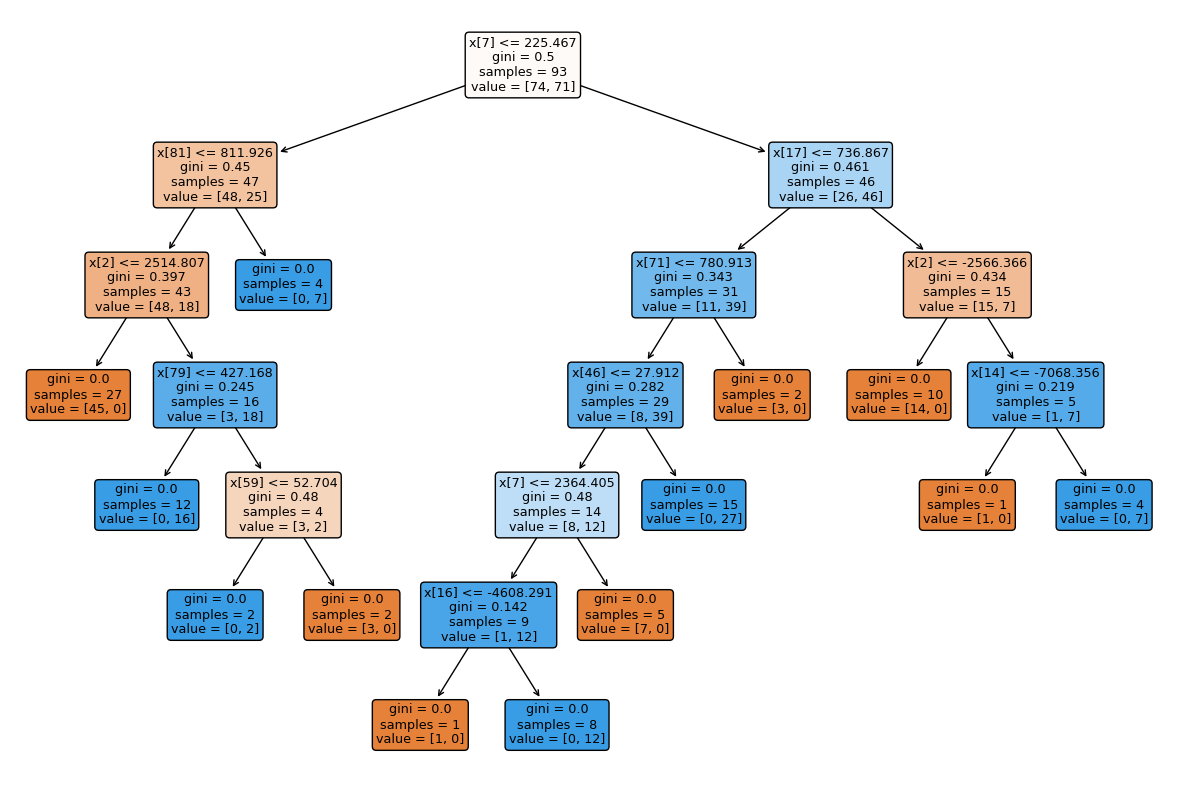

In [6]:
fig = plt.figure(figsize=(15, 10))
plot_tree(random_forest_simple.named_steps["rf"].estimators_[2],  
          filled=True, impurity=True, 
          rounded=True)

In [7]:
model_metrics(random_forest_simple, X1_test, y1_test)

(0.8918918918918919, 0.8571428571428571, 0.9473684210526315)

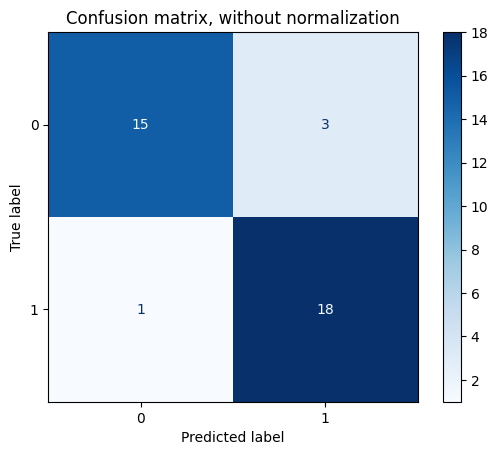

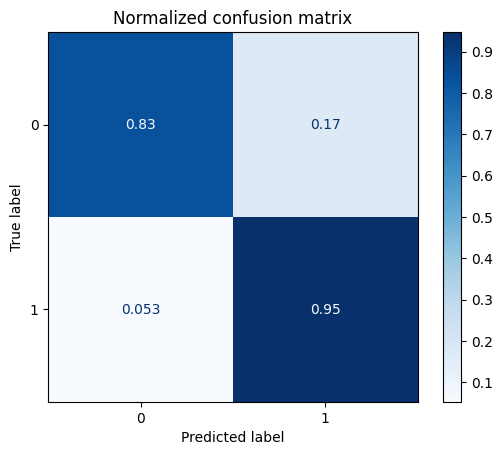

In [8]:
show_confusion_matrix(random_forest_simple, X1_test, y1_test)

Let's optimize this model to fit to this data

In [9]:
random_forest = Pipeline([
    ("pca", PCA()),
    ("rf", RandomForestClassifier())
])

random_forest_param_grid = {
    "pca__n_components" : np.arange(10, 100),
    "rf__n_estimators" : np.arange(145, 1000),
    "rf__criterion" : ["gini", "entropy", "log_loss"],
    "rf__max_samples" : np.arange(2, 145)
    
}

random_forest_grid_search = RandomizedSearchCV(random_forest, random_forest_param_grid, n_iter=50, random_state = 12, scoring="accuracy", verbose = 4)
random_forest_grid_search.fit(X1_train, y1_train)

print(f"Best parameters: {random_forest_grid_search.best_params_}")
print(f"Best accuracy: {random_forest_grid_search.best_score_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END pca__n_components=77, rf__criterion=gini, rf__max_samples=19, rf__n_estimators=500;, score=0.966 total time=   1.7s
[CV 2/5] END pca__n_components=77, rf__criterion=gini, rf__max_samples=19, rf__n_estimators=500;, score=0.966 total time=   0.9s
[CV 3/5] END pca__n_components=77, rf__criterion=gini, rf__max_samples=19, rf__n_estimators=500;, score=1.000 total time=   0.7s
[CV 4/5] END pca__n_components=77, rf__criterion=gini, rf__max_samples=19, rf__n_estimators=500;, score=1.000 total time=   1.1s
[CV 5/5] END pca__n_components=77, rf__criterion=gini, rf__max_samples=19, rf__n_estimators=500;, score=1.000 total time=   1.0s
[CV 1/5] END pca__n_components=20, rf__criterion=entropy, rf__max_samples=136, rf__n_estimators=539;, score=nan total time=   0.0s
[CV 2/5] END pca__n_components=20, rf__criterion=entropy, rf__max_samples=136, rf__n_estimators=539;, score=nan total time=   0.0s
[CV 3/5] END pca__n_components=

KeyboardInterrupt: 

In [ ]:
random_forest_final = random_forest_grid_search.best_estimator_

model_metrics(random_forest_final, X1_test, y1_test)

Let's now use another model, XGBoost 

In [10]:
def xgboost_grid_search_model(X_train, y_train):


    # Define the hyperparameter grid for each group
    group1_grid = {
        'max_depth': [3, 5, 7],
            'min_child_weight': [1, 3, 5]
    }

    group2_grid = {
        'subsample': [0.5, 0.7, 1],
        'colsample_bytree': [0.5, 0.7, 1]
    }

    group3_grid = {
        'learning_rate': [0.1, 0.01, 0.001],
        'num_boost_round': [1000, 2000, 3000]
    }

    # Create the XGBoost model object
    xgb_model = xgb.XGBClassifier()


    # Tune each group sequentially
    for param_grid in [group1_grid, group2_grid, group3_grid]:
        grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        
        xgb_model.set_params(**grid_search.best_params_)
        print(f"Best accuracy so far : {grid_search.best_score_}")

    # Print the best set of hyperparameters and the corresponding score
    print("Best set of hyperparameters: ", xgb_model.get_params())

    return xgb_model.fit(X_train, y_train)


In [11]:
xgb_hcc_smarts = xgboost_grid_search_model(X1_train, y1_train)

Best accuracy so far : 0.9793103448275862
Best accuracy so far : 0.993103448275862
[02:28:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "num_boost_round" } are not used.

[02:28:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "num_boost_round" } are not used.

[02:29:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "num_boost_round" } are not used.

[02:29:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "num_boost_round" } are not used.

[02:29:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd9

In [13]:
model_metrics(xgb_hcc_smarts, X1_test, y1_test)

(0.9459459459459459, 1.0, 0.8947368421052632)

As we can see xgboost gives 1 as accuracy precision and recall on the test dataset so we try to use it also on the mcf7 dataset in smartseq and see if it works.

In [31]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2) 

print( f"X_train size : {X2_train.shape}   X_test size : {X2_test.shape}    y_train size : {y2_train.shape}    y_test size :{y2_test.shape}")

X_train size : (200, 3000)   X_test size : (50, 3000)    y_train size : (200,)    y_test size :(50,)


In [32]:
xgb_mcf_smart = xgboost_grid_search_model(X2_train, y2_train)

Best accuracy so far : 0.99
Best accuracy so far : 1.0
[18:18:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_boost_round" } are not used.

[18:18:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_boost_round" } are not used.

[18:18:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_boost_round" } are not used.

[18:18:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_boost_round" } are not used.

[18:18:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_boost_round" } are not used.



In [33]:
model_metrics(xgb_mcf_smart, X2_test, y2_test)

(1.0, 1.0, 1.0)

Again we found 1, 1, 1 as accuracy, precision and recall scores. So now we find the model for the dropseq method.

In [35]:
hcc_drops_df_train = pd.read_csv("data/dropSeq/HCC1806_Filtered_Normalised_3000_Data_train.txt", sep = " ")
mcf_drops_df_train = pd.read_csv("data/dropSeq/MCF7_Filtered_Normalised_3000_Data_train.txt", sep= " ")

hcc_drops_df_train = add_label_T(hcc_drops_df_train)
mcf_drops_df_train = add_label_T(mcf_drops_df_train)

X3 = hcc_drops_df_train.loc[:,hcc_drops_df_train.columns!='label']
X4 = mcf_drops_df_train.loc[:,mcf_drops_df_train.columns!='label']
y3 = hcc_drops_df_train["label"]
y4 = mcf_drops_df_train["label"]

In [36]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2) 

print( f"X_train size : {X3_train.shape}   X_test size : {X3_test.shape}    y_train size : {y3_train.shape}    y_test size :{y3_test.shape}")

X_train size : (11745, 3000)   X_test size : (2937, 3000)    y_train size : (11745,)    y_test size :(2937,)


In [44]:
xgb_hcc_drops = xgb.XGBClassifier(verbosity = 2)
xgb_hcc_drops.fit(X3_train, y3_train)

[19:05:36] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[19:05:37] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:05:38] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:05:40] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:05:42] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 114

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [45]:
model_metrics(xgb_hcc_drops, X3_test, y3_test)

(0.9564181137214846, 0.9554436740646648, 0.952795536729605)

In [46]:
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2) 

print( f"X_train size : {X4_train.shape}   X_test size : {X4_test.shape}    y_train size : {y4_train.shape}    y_test size :{y4_test.shape}")

X_train size : (17300, 3000)   X_test size : (4326, 3000)    y_train size : (17300,)    y_test size :(4326,)


In [47]:
xgb_mcf_drops = xgb.XGBClassifier()
xgb_mcf_drops.fit(X4_train, y4_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [48]:
model_metrics(xgb_mcf_drops, X4_test, y4_test)

(0.9794267221451688, 0.9799757852485296, 0.9775143264056017)

In [ ]:
show_confusion_matrix(xgb_mcf_drops, X4_test, y4_test)